<a href="https://colab.research.google.com/github/MuhammadZafir/MNIST-Digit-Recognition-Project/blob/main/MNIST_Digit_Recognition_Project_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Run this cell once to install libraries.
!pip install gradio numpy scikit-learn matplotlib --quiet

In [ ]:
# Run this cell to import all necessary modules.
import numpy as np
import gradio as gr
from google.colab import output # Specific for Google Colab environment
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import random # For potential future data augmentation

In [ ]:
# Run this cell once to load and prepare the dataset.
print("Step 1: Loading MNIST dataset...")
# (a) Load MNIST dataset (fetch_openml('mnist_784'))
# version=1 is important for consistency, as_frame=False returns NumPy arrays
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X, y = mnist.data, mnist.target

# Convert target labels to integers
y = y.astype(np.uint8)

# Normalize pixel values to be between 0 and 1
# This is a common and effective preprocessing step for image data.
X = X / 255.0

print(f"Dataset loaded. X shape: {X.shape}, y shape: {y.shape}")

# (b) Split data (60k train, 10k test)
# Manually split to ensure exact 60k/10k split as specified
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

print(f"Data split: X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Data split: y_train: {y_train.shape}, y_test: {y_test.shape}")

Step 1: Loading MNIST dataset...
Dataset loaded. X shape: (70000, 784), y shape: (70000,)
Data split: X_train: (60000, 784), X_test: (10000, 784)
Data split: y_train: (60000,), y_test: (10000,)


In [ ]:
# Cell 4: Model Training
# Run this cell to train your classifiers. Only re-run if you change model parameters.
print("\nStep 2: Training Classifiers...")

# (c) Train classifiers:
# SGD Classifier (with hinge loss - for linear SVM)
print("Training SGD Classifier (loss='hinge')...")
sgd_clf = SGDClassifier(loss='hinge', random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train, y_train)
print("SGD Classifier training complete.")

# Random Forest Classifier
print("Training Random Forest Classifier...")
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1) # n_jobs=-1 uses all available cores
rf_clf.fit(X_train, y_train)
print("Random Forest Classifier training complete.")



Step 2: Training Classifiers...
Training SGD Classifier (loss='hinge')...
SGD Classifier training complete.
Training Random Forest Classifier...
Random Forest Classifier training complete.


In [ ]:
# Cell 5: Model Evaluation
# Run this cell to evaluate the trained models.
print("\nStep 3: Evaluating Classifiers...")

# Predictions on the test set
y_pred_sgd = sgd_clf.predict(X_test)
y_pred_rf = rf_clf.predict(X_test)

# (d) Evaluate using confusion matrix & classification report

# SGD Classifier Evaluation
print("\n--- SGD Classifier Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred_sgd))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_sgd))
print("\nClassification Report:\n", classification_report(y_test, y_pred_sgd))

# Random Forest Classifier Evaluation
print("\n--- Random Forest Classifier Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Step 3: Evaluating Classifiers...

--- SGD Classifier Evaluation ---
Accuracy: 0.9174

Confusion Matrix:
 [[ 956    0    2    2    0    3   12    3    1    1]
 [   0 1112    3    1    0    3    5    1   10    0]
 [   8    5  934   13    6    2   14   13   33    4]
 [   5    0   26  902    2   30    3   13   21    8]
 [   1    3    5    0  888    0   20    5    8   52]
 [  12    3    1   24   12  777   24    5   27    7]
 [   7    3    6    2    6    7  925    0    2    0]
 [   2    8   23    3    7    1    1  949    3   31]
 [  12   12    8   17   15   38   11   14  834   13]
 [  10    8    2   17   28   12    0   27    8  897]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.91      0.91      1032
           3       0.92      0.89      0.91      1010
           4       0.92      0.90      0.91       982
           5


Step 4: Visualizing Worst Misclassifications (Random Forest)...
Found 296 misclassified samples by Random Forest.
Plotting top 10 worst misclassifications.


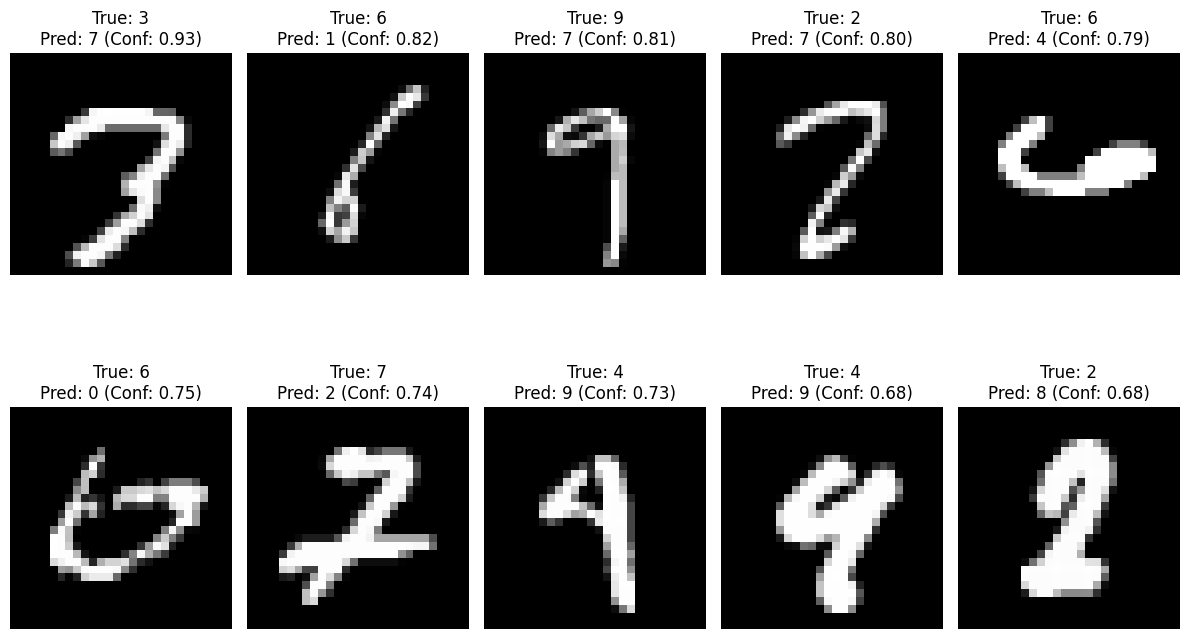

In [ ]:
# Cell 6: Error Visualization (Plot worst misclassifications for Random Forest)
# Run this cell to visualize errors.
print("\nStep 4: Visualizing Worst Misclassifications (Random Forest)...")

# Get probabilities for all classes for the test set
rf_probas = rf_clf.predict_proba(X_test)

# Identify misclassified samples
misclassified_indices = np.where(y_pred_rf != y_test)[0]
print(f"Found {len(misclassified_indices)} misclassified samples by Random Forest.")

# Sort misclassified samples by prediction confidence for the *incorrect* class
# A higher probability for the predicted (incorrect) class means higher confidence in the error.
# We want to see cases where the model was confident but wrong.

# Store (index, predicted_proba_for_incorrect_class) for misclassified samples
misclassification_confidences = []
for idx in misclassified_indices:
    predicted_class = y_pred_rf[idx]
    confidence_in_incorrect_pred = rf_probas[idx, predicted_class]
    misclassification_confidences.append((idx, confidence_in_incorrect_pred))

# Sort by confidence in descending order (worst misclassifications first)
misclassification_confidences.sort(key=lambda x: x[1], reverse=True)

# Plot the top N worst misclassifications
num_to_plot = min(10, len(misclassification_confidences)) # Plot up to 10
print(f"Plotting top {num_to_plot} worst misclassifications.")

plt.figure(figsize=(12, 8))
for i in range(num_to_plot):
    original_idx = misclassification_confidences[i][0]
    confidence = misclassification_confidences[i][1]

    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[original_idx].reshape(28, 28) * 255, cmap='gray', vmin=0, vmax=255) # Rescale back to 0-255 for display
    plt.title(f"True: {y_test[original_idx]}\nPred: {y_pred_rf[original_idx]} (Conf: {confidence:.2f})")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Cell 7: Gradio Web App Definition and Launch
# Run this cell to define and launch your Gradio app.
# You can re-run this cell multiple times after making changes to predict_digit_gradio
# without re-running training.
print("\nStep 5: Deploying as Gradio Web App...")

def predict_digit_gradio(input_data):
    """
    Handles sketchpad input from Gradio, preprocesses it, and makes predictions
    using the trained Random Forest Classifier.

    Args:
        input_data: The input from Gradio's gr.Sketchpad.
                    This is typically a dictionary {'background': ..., 'layers': ..., 'composite': numpy_array}
                    or a numpy_array directly for older Gradio versions.

    Returns:
        A dictionary formatted for gr.Label, containing predicted class probabilities.
        Returns a "No drawing detected" or "Error" message with 0.0 confidence if issues occur.
    """
    image = None # Initialize image variable

    # Robustly extract the image data from input_data
    if isinstance(input_data, dict):
        # Gradio's gr.Sketchpad often returns the final image in the 'composite' key
        if 'composite' in input_data and input_data['composite'] is not None:
            image = input_data['composite']
        # Fallback for older Gradio versions or other image inputs that might use 'image' key
        elif 'image' in input_data and input_data['image'] is not None:
            image = input_data['image']
        else:
            # If no valid image data found in expected keys
            return {"No drawing detected": 0.0}
    elif isinstance(input_data, np.ndarray):
        image = input_data
    else:
        # Handle truly unexpected input types
        return {"Error: Invalid input format": 0.0}

    # Ensure the image is a NumPy array and not empty
    if image is None or (isinstance(image, np.ndarray) and image.size == 0):
        return {"No drawing detected": 0.0}

    image = np.asarray(image)

    # Convert to grayscale if needed (Sketchpad often returns RGBA)
    if image.ndim == 3 and image.shape[2] >= 3:
        image = image[:, :, :3].mean(axis=2) # Take mean of RGB channels

    # Define target size for MNIST (28x28)
    target_size = (28, 28)

    # Resize the image to 28x28
    if image.shape != target_size:
        h, w = image.shape
        if h == 0 or w == 0:
            return {"No drawing detected": 0.0}

        scale_x = w / target_size[1]
        scale_y = h / target_size[0]

        j, i = np.meshgrid(
            np.clip((np.arange(target_size[1]) * scale_x).astype(int), 0, w - 1),
            np.clip((np.arange(target_size[0]) * scale_y).astype(int), 0, h - 1)
        )
        image = image[i, j]

    # Invert colors: Sketchpad draws black on white, but MNIST models expect white on black
    image = 255 - image

    # Normalize pixel values to be between 0 and 1
    # Avoid division by zero if image is completely black (all zeros after inversion)
    image_flat = image.reshape(1, -1)
    if np.max(image_flat) > 0:
        image_normalized = image_flat / np.max(image_flat) # Normalize based on actual max
    else:
        # If image is all zeros after inversion (i.e., blank canvas), return no drawing
        return {"No drawing detected": 0.0}

    # Check if the drawing is too faint after normalization (optional, but good for robustness)
    # If the sum of pixel values is very low, it might be an empty drawing.
    if np.sum(image_normalized) < 5: # Threshold can be tuned
        return {"No drawing detected": 0.0}

    # Get predictions from the Random Forest Classifier
    try:
        rf_proba = rf_clf.predict_proba(image_normalized)[0]
        # Format for gr.Label: dictionary where keys are class labels (strings) and values are probabilities (floats)
        rf_results = {str(i): prob for i, prob in enumerate(rf_proba)}

        return rf_results

    except Exception as e:
        print(f"Error during prediction: {e}")
        return {"Prediction Error": 0.0}

# Enable custom widget manager for Gradio in Colab
output.enable_custom_widget_manager()

# Cell 7: Gradio Web App Definition and Launch
# ... (previous code in Cell 7) ...

# Create Gradio interface
interface = gr.Interface(
    fn=predict_digit_gradio,
    inputs=gr.Sketchpad(image_mode="L"), # Removed brush_radius argument
    outputs="label",
    title="MNIST Digit Recognition",
    description="Draw a digit (0-9) on the white canvas with a black brush. The model is trained on the MNIST dataset (28x28 pixels).",
    live=True
)

# Launch the Gradio app
interface.launch(debug=True)


Step 5: Deploying as Gradio Web App...
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://743903bdc3d8584a8c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
